# What do you like in board games - Text Mining and Sentiment Analysis Project

In [1]:
# To run it in colab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/NLP')

Mounted at /content/drive


In [1]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import spacy
#import en_core_web_lg

import gensim.corpora as corpora
from gensim.models import LdaMulticore
from pprint import pprint

from gensim.models import FastText
import fasttext

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import customized classes and functions
from HelperFunction import *
from Vocabulary import *
from CustomDataset import *
from SA_classes import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marsone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marsone\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Dataset Preparation

In [ ]:
data = pd.read_csv('bgg-15m-reviews.csv')
df = data.drop(columns=["Unnamed: 0", 'user', 'ID'])
df.count()

rating     15823269
comment     2995022
name       15823269
dtype: int64

In [ ]:
# Removing the rows without comments
df = df[df.comment.notna()]

# Removing the non ascii comments
df = df[df['comment'].map(lambda x: x.isascii())]

# Counting the words
df['word_count'] = df.comment.str.split().str.len()

# Round the ratings
df['rating'] = df.rating.apply(lambda x: round(x))
df

,rating,comment,name,word_count
2,10,I tend to either love or easily tire of co-op ...,Pandemic,73
4,10,This is an amazing co-op game. I play mostly ...,Pandemic,59
5,10,Hey! I can finally rate this game I've been pl...,Pandemic,215
8,10,Love it- great fun with my son. 2 plays so far...,Pandemic,16
9,10,"Fun, fun game. Strategy is required, but defin...",Pandemic,99
...,...,...,...,...
15823240,10,Buy it..... please,Company of Heroes,3
15823242,10,KS Collector's Bundle with a friend of mine,Company of Heroes,8
15823247,10,Belekokio Gerumo...,Company of Heroes,2
15823264,8,Turn based preview looks very promising. The g...,Company of Heroes,95


In [ ]:
# Keeping only the comments that contains more than 10 words
df = df[(df.word_count > 10)]
df

,rating,comment,name,word_count
2,10,I tend to either love or easily tire of co-op ...,Pandemic,73
4,10,This is an amazing co-op game. I play mostly ...,Pandemic,59
5,10,Hey! I can finally rate this game I've been pl...,Pandemic,215
8,10,Love it- great fun with my son. 2 plays so far...,Pandemic,16
9,10,"Fun, fun game. Strategy is required, but defin...",Pandemic,99
...,...,...,...,...
15823218,7,This is a game that sneaks up on you with its ...,Beasty Borders,24
15823221,7,"Nice little abstract strategy, only played onc...",Beasty Borders,47
15823224,7,"Straightforward 2p abstract, lifted by the bea...",Beasty Borders,26
15823230,6,This is a cute but silly game. It is heavily l...,Beasty Borders,24


## 1.1 Resampling

In [ ]:
df.rating.value_counts(sort=True)

rating
8     493525
7     424522
6     398021
9     185593
5     166703
10    118681
4     107280
3      55920
2      31353
1      14824
0          5
Name: count, dtype: int64

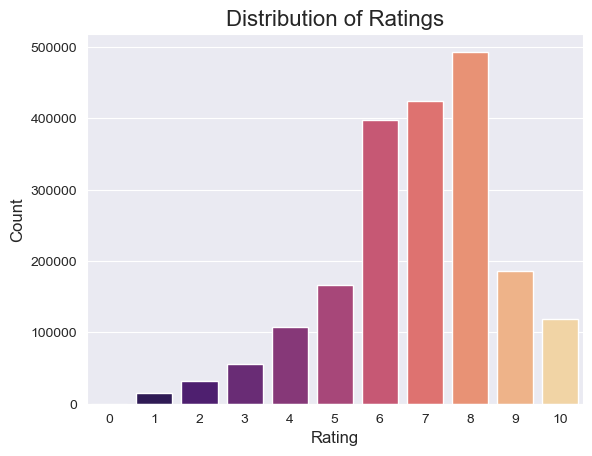

In [ ]:
# Plot the distribution
df.rating.value_counts()

sns.set_style("darkgrid")
sns.countplot(x="rating", data=df, palette="magma")

plt.title("Distribution of Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

In [ ]:
df_class_0 = df[df['rating'] == 0]
df_class_1 = df[df['rating'] == 1]
df_class_2 = df[df['rating'] == 2]
df_class_3 = df[df['rating'] == 3]
df_class_4 = df[df['rating'] == 4]
df_class_5 = df[df['rating'] == 5]
df_class_6 = df[df['rating'] == 6]
df_class_7 = df[df['rating'] == 7]
df_class_8 = df[df['rating'] == 8]
df_class_9 = df[df['rating'] == 9]
df_class_10 = df[df['rating'] == 10]

In [ ]:
# All the classes are sampled into the length of a class with minimum size i.e "df_class_1" for balancing the data.

df_rating_2_under = df_class_2.sample(len(df_class_1))
df_rating_3_under = df_class_3.sample(len(df_class_1))
df_rating_4_under = df_class_4.sample(len(df_class_1))
df_rating_5_under = df_class_5.sample(len(df_class_1))
df_rating_6_under = df_class_6.sample(len(df_class_1))
df_rating_7_under = df_class_7.sample(len(df_class_1))
df_rating_8_under = df_class_8.sample(len(df_class_1))
df_rating_9_under = df_class_9.sample(len(df_class_1))
df_rating_10_under = df_class_10.sample(len(df_class_1))

df_under = pd.concat([ df_class_1, df_rating_2_under, df_rating_3_under, df_rating_4_under, df_rating_5_under, df_rating_6_under, df_rating_7_under, df_rating_8_under, df_rating_9_under, df_rating_10_under], axis=0)

print('Size after Random under-sampling:',len(df_under))

Size after Random under-sampling: 148240


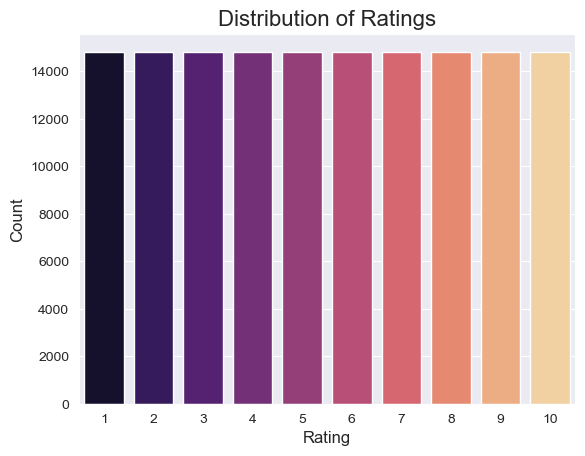

In [ ]:
# Plot the distribution
df_under.rating.value_counts()

sns.set_style("darkgrid")
sns.countplot(x="rating", data=df_under, palette="magma")

plt.title("Distribution of Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

## 1.2 Assigning label

In [ ]:
# Assign a label: 1 if the comment is positive (rating>5), 0 otherwise
def label(y):
    if y > 5:
        return 1
    else:
        return 0

df_under['y'] = df_under['rating'].progress_map(label)

df_under = df_under[['name', 'comment', 'y', 'rating']]
df_under

100%|██████████| 148240/148240 [00:00<00:00, 477572.54it/s]


,name,comment,y,rating
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1
...,...,...,...,...
6565382,Burgle Bros.,"This one is hard. Then again, a successful thr...",1,10
7405559,Eight-Minute Empire,Eight-Minute Empire is the super-quick area co...,1,10
3674444,Welcome To...,Great game. + Easy learn (despite the poor ru...,1,10
499812,Gloomhaven,Incredibly complex game when you first try pla...,1,10


In [ ]:
df_under.y.value_counts()

y
0    74120
1    74120
Name: count, dtype: int64

## 1.3 Cleaning the texts

In [10]:
# Set up lemmatizer and stopwords
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [ ]:
# Cleaning the text
df_under['clean_review'] = df_under.comment.apply(lambda x: clean_text(x,lemmatizer,stop_words))
df_under

,name,comment,y,rating,clean_review
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...
...,...,...,...,...,...
6565382,Burgle Bros.,"This one is hard. Then again, a successful thr...",1,10,one hard successful threefloor bank heist woul...
7405559,Eight-Minute Empire,Eight-Minute Empire is the super-quick area co...,1,10,eightminute empire superquick area control gam...
3674444,Welcome To...,Great game. + Easy learn (despite the poor ru...,1,10,great game easy learn despite poor rulebook pl...
499812,Gloomhaven,Incredibly complex game when you first try pla...,1,10,incredibly complex game first try play scenari...


In [ ]:
# Saving DataFrame to Excel file
#df_under.to_csv('df_under.csv', index=False)

# 2. Aspects Classification

## 2.1 LDA

In [ ]:
# Tokenize the text
df_under['clean_review2'] = df_under['clean_review'].progress_map(word_tokenizer)
df_under.head()

100%|██████████| 148240/148240 [00:01<00:00, 90521.41it/s]


,name,comment,y,rating,clean_review,clean_review2
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ..."
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man..."
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie..."
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla..."
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam..."


In [ ]:
# Getting the length of the list of words
data_words = df_under['clean_review2'].values.tolist()
len_data_words = len(data_words)
print("The length of the list of words is:", len_data_words)

The length of the list of words is: 148240


In [ ]:
# Create dictionary where each unique word in 'data_words' is assigned a unique numeric ID
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [ ]:
# Number of topics = Number of aspects
# Aspects: ["general", "luck", "bookkeeping", "downtime", "interaction", "bash the leader", "complicated vs complex"]
num_topics = 7

# Build LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, iterations=400)

# Print the keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.058*"game" + 0.032*"play" + 0.018*"star" + 0.012*"like" + 0.011*"really" '
  '+ 0.010*"wa" + 0.010*"get" + 0.009*"rule" + 0.009*"good" + 0.009*"nostar"'),
 (1,
  '0.044*"game" + 0.026*"card" + 0.025*"play" + 0.011*"player" + 0.010*"fun" + '
  '0.009*"good" + 0.009*"one" + 0.009*"time" + 0.007*"theme" + 0.006*"like"'),
 (2,
  '0.043*"game" + 0.027*"play" + 0.012*"one" + 0.010*"rule" + 0.009*"like" + '
  '0.009*"card" + 0.008*"love" + 0.008*"great" + 0.008*"much" + 0.008*"get"'),
 (3,
  '0.068*"game" + 0.033*"play" + 0.015*"player" + 0.012*"one" + 0.010*"like" + '
  '0.008*"time" + 0.007*"get" + 0.007*"wa" + 0.007*"make" + 0.007*"fun"'),
 (4,
  '0.049*"game" + 0.019*"play" + 0.018*"like" + 0.012*"dice" + 0.011*"one" + '
  '0.011*"card" + 0.011*"player" + 0.010*"fun" + 0.009*"really" + '
  '0.008*"roll"'),
 (5,
  '0.047*"game" + 0.046*"play" + 0.020*"time" + 0.013*"fun" + 0.008*"ever" + '
  '0.007*"great" + 0.006*"interest" + 0.006*"dont" + 0.006*"make" + '
  '0.005*"get"'),
 (6

In [ ]:
#Create a similarity matrix now using python's gensim
fasttext_model = FastText(data_words, vector_size= 100, window=5, min_count=5, workers=4,sg=1)

In [ ]:
fasttext_model.save("FastText-Model-For-ABSA.bin")

## 2.2 Fasttext - Gensim Library

In [ ]:
# Define the model
unsuper_model = FastText(data_words, vector_size=100, window=5, min_count=5, workers=4, sg=1)

### fasttext_list

In [ ]:
# Define the list of aspects
aspects_list = ['general', 'luck', 'bookkeeping', 'downtime', 'interaction', 'bash the leader', 'complicated vs complex']

df_under['fasttext_list'], df_under['fasttext_list_score'] = zip(*df_under['clean_review2'].progress_map(lambda text: get_max_similarity(text, aspects_list, unsuper_model)))

100%|██████████| 148240/148240 [1:11:27<00:00, 34.57it/s]


In [ ]:
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list_score
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ...",general,0.966579
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man...",bash the leader,0.951985
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie...",bash the leader,0.969672
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla...",general,0.932806
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam...",bash the leader,0.975213


In [ ]:
df_under['fasttext_list'].value_counts()

fasttext_list
general                   82090
bash the leader           56238
complicated vs complex     4685
interaction                2438
bookkeeping                1700
downtime                    683
luck                        404
Name: count, dtype: int64

### fasttext_list2

In [ ]:
df_under.drop('fasttext_list_score', axis=1, inplace=True)

KeyError: "['fasttext_list_score'] not found in axis"

In [ ]:
# Same procedure as before, but "general" will be assigned later with a threshold
aspects_list = ['luck', 'bookkeeping', 'downtime', 'interaction', 'bash the leader', 'complicated vs complex']

df_under['fasttext_list2'], df_under['fasttext_list2_score'] = zip(*df_under['clean_review2'].progress_map(lambda text: get_max_similarity(text, aspects_list, unsuper_model)))

  0%|          | 9/148240 [00:00<30:51, 80.07it/s]

100%|██████████| 148240/148240 [1:27:52<00:00, 28.11it/s]    


In [ ]:
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_list2_score
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ...",general,bash the leader,0.949134
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man...",bash the leader,bash the leader,0.951985
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie...",bash the leader,bash the leader,0.969672
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla...",general,bash the leader,0.923859
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam...",bash the leader,bash the leader,0.975213


In [ ]:
df_under['fasttext_list2'].value_counts()

fasttext_list2
bash the leader           129240
complicated vs complex      5857
interaction                 5754
bookkeeping                 4556
downtime                    2408
luck                         423
Name: count, dtype: int64

In [ ]:
# Compute the average similarity score for each aspect
aspect_scores_mean = df_under.groupby('fasttext_list2')['fasttext_list2_score'].mean()
aspect_scores_std = df_under.groupby('fasttext_list2')['fasttext_list2_score'].std()

In [ ]:
# Iterate over each aspect and update 'fasttext_list' column
for aspect in aspects_list:
    df_under.loc[(df_under['fasttext_list2'] == aspect) & (df_under['fasttext_list2_score'] < (aspect_scores_mean[aspect] + aspect_scores_std[aspect])), 'fasttext_list2'] = 'general'

In [ ]:
df_under['fasttext_list2'].value_counts()

fasttext_list2
general                   130677
bash the leader            16108
interaction                  514
bookkeeping                  484
complicated vs complex       262
downtime                     156
luck                          37
Name: count, dtype: int64

### fasttext_dict

In [ ]:
df_under.drop('fasttext_list2_score', axis=1, inplace=True)

In [ ]:
aspects_dict = {
    'luck': ['luck', 'alea', 'unpredictable', 'game elements', 'random', 'chance'],
    'bookkeeping': ['manual recording', 'data', 'rulebook', 'reference', 'check'],
    'downtime': ['waiting time', 'unproductive', 'player turn', 'nothing to do'],
    'interaction': ['interaction','influence', 'player actions', 'other participants'],
    'bash the leader': ['prevent victory', 'take actions', 'against leader', 'sacrifice'],
    'complicated vs complex': ['complicated', 'rules', 'exceptions', 'complex', 'repercussions', 'difficult to predict']
}

In [ ]:
df_under['fasttext_dict'], df_under['fasttext_dict_score'] = zip(*df_under['clean_review2'].progress_map(lambda text: get_max_similarity(text, aspects_dict, unsuper_model)))

100%|██████████| 148240/148240 [18:49<00:00, 131.25it/s]


In [ ]:
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_dict_score
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ...",general,general,bash the leader,0.949134
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man...",bash the leader,general,bash the leader,0.951985
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie...",bash the leader,general,bash the leader,0.969672
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla...",general,general,bash the leader,0.923859
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam...",bash the leader,bash the leader,bash the leader,0.975213


In [ ]:
df_under['fasttext_dict'].value_counts()

fasttext_dict
bash the leader           129240
complicated vs complex      5857
interaction                 5754
bookkeeping                 4556
downtime                    2408
luck                         423
Name: count, dtype: int64

In [ ]:
aspect_scores_mean = df_under.groupby('fasttext_dict')['fasttext_dict_score'].mean()
aspect_scores_std = df_under.groupby('fasttext_dict')['fasttext_dict_score'].std()

In [ ]:
for aspect in aspects_list:
    df_under.loc[(df_under['fasttext_dict'] == aspect) & (df_under['fasttext_dict_score'] < (aspect_scores_mean[aspect] + aspect_scores_std[aspect])), 'fasttext_dict'] = 'general'

In [ ]:
df_under['fasttext_dict'].value_counts()

fasttext_dict
general                   130677
bash the leader            16108
interaction                  514
bookkeeping                  484
complicated vs complex       262
downtime                     156
luck                          37
Name: count, dtype: int64

### fasttext_full

In [ ]:
aspects_dict_full = {
    'luck': ['alea, all those game elements independent of player intervention, introduced by game mechanics outside the control of the players.'],
    'bookkeeping': ['manual recording of data and potentially automatic or semi-automatic game processes, including also the need of continuosly accessing the rulebook for reference'],
    'downtime': ['unproductive waiting time between one player turn and the next. By unproductive we mean not only having nothing (or little) to do, but also nothing (or little) to think about'],
    'interaction': ['the degree of influence that one player\'s actions have on the actions of the other participants'],
    'bash the leader': ['when, to prevent the victory of whoever is first, the players are forced to take actions against him, often to the detriment of their own advantage or in any case without gaining anything directly. At the table, the unfortunate situation can arise whereby one or more must "sacrifice" themselves to curb the leader and let the others benefit from this conduct'],
    'complicated vs complex': ['A game is complicated the more the rules are quantitatively many and qualitatively equipped with exceptions. Once you understand and learn all the variables, a game (that is only) complicated is not difficult to master. In a complicated game, solving a problem leads to immediate, certain and predictable results. A game is as complex as the repercussions of one\'s actions are difficult to predict and master. Even once you understand and learn all the variables, a complex game is still difficult to master. In a complex game, solving one problem leads to other problems. ']
}

In [ ]:
df_under['fasttext_full'], df_under['fasttext_full_score'] = zip(*df_under['clean_review2'].progress_map(lambda text: get_max_similarity(text, aspects_dict_full, unsuper_model)))

100%|██████████| 148240/148240 [18:27<00:00, 133.90it/s]


In [ ]:
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_dict_score,fasttext_full,fasttext_full_score
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ...",general,general,general,0.949134,bash the leader,0.949134
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man...",bash the leader,general,general,0.951985,bash the leader,0.951985
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie...",bash the leader,general,general,0.969672,bash the leader,0.969672
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla...",general,general,general,0.923859,bash the leader,0.923859
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam...",bash the leader,bash the leader,bash the leader,0.975213,bash the leader,0.975213


In [ ]:
df_under['fasttext_full'].value_counts()

fasttext_full
bash the leader           129240
complicated vs complex      5857
interaction                 5754
bookkeeping                 4556
downtime                    2408
luck                         423
Name: count, dtype: int64

In [ ]:
aspect_scores_mean = df_under.groupby('fasttext_full')['fasttext_full_score'].mean()
aspect_scores_std = df_under.groupby('fasttext_full')['fasttext_full_score'].std()

In [ ]:
for aspect in aspects_list:
    df_under.loc[(df_under['fasttext_full'] == aspect) & (df_under['fasttext_full_score'] < (aspect_scores_mean[aspect] + aspect_scores_std[aspect])), 'fasttext_full'] = 'general'

In [ ]:
df_under['fasttext_full'].value_counts()

fasttext_full
general                   130677
bash the leader            16108
interaction                  514
bookkeeping                  484
complicated vs complex       262
downtime                     156
luck                          37
Name: count, dtype: int64

In [ ]:
df_under.drop(['fasttext_dict_score', 'fasttext_full_score'], axis=1, inplace=True)
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_full
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ...",general,general,general,general
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man...",bash the leader,general,general,general
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie...",bash the leader,general,general,general
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla...",general,general,general,general
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam...",bash the leader,bash the leader,bash the leader,bash the leader


## 2.3 Fasttext - fastText Library

In [ ]:
# Training the model
train_path = 'train.txt'
super_model = fasttext.train_supervised(input=train_path, epoch=1000)

In [ ]:
# Predictions
df_under['prediction'] = df_under['clean_review'].apply(lambda x: super_model.predict(x)[0][0].replace('__label__', ''))
df_under['confidence'] = df_under['clean_review'].apply(lambda x: super_model.predict(x)[1][0])

# Calculate mean confidence for each label
label_means = df_under.groupby('prediction')['confidence'].mean().reset_index()

std_conf = df_under['confidence'].std()
# Substitute predicted label with 'general' if confidence is smaller than the label's mean confidence
df_under = pd.merge(df_under, label_means, on='prediction', suffixes=('', '_mean'))
df_under.loc[df_under['confidence'] < (df_under['confidence_mean'] + std_conf), 'prediction'] = 'general'

# Drop the mean confidence column
df_under.drop('confidence_mean', axis=1, inplace=True)
df_under

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_full,prediction,confidence
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ...",general,general,general,general,general,0.853809
1,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie...",bash the leader,general,general,general,general,0.728985
2,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla...",general,general,general,general,general,0.853809
3,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam...",bash the leader,bash the leader,bash the leader,bash the leader,general,0.778858
4,Cards Against Humanity,"Because of the subject matter, this deserves ...",0,1,subject matter deserve vilification get wa re...,"[subject, matter, deserve, vilification, get, ...",bash the leader,general,general,general,general,0.778858
...,...,...,...,...,...,...,...,...,...,...,...,...
148235,Mystery Rummy: Jack the Ripper,Initial play took a while to learn (and explai...,1,10,initial play take learn explain significant ru...,"[initial, play, take, learn, explain, signific...",bash the leader,general,general,general,general,0.237180
148236,Twilight Struggle,The fun and strategy of a wargame without anyt...,1,10,fun strategy wargame without anything bog warg...,"[fun, strategy, wargame, without, anything, bo...",bash the leader,general,general,general,general,0.322327
148237,The Guns of Gettysburg,[COLOR=#CC0033][b]Another masterpiece from Bow...,1,10,colorcc banother masterpiece bowen simmons fee...,"[colorcc, banother, masterpiece, bowen, simmon...",bash the leader,bash the leader,bash the leader,bash the leader,general,0.312948
148238,Triumph & Tragedy: European Balance of Power 1...,Certainly the best strategic WW2 ever ! And m...,1,10,certainly best strategic ww ever understand hi...,"[certainly, best, strategic, ww, ever, underst...",general,general,general,general,general,0.273331


In [ ]:
df_under['prediction'].value_counts()

prediction
general                   136195
luck_alea                   5591
downtime                    2948
bookkeeping                 2621
complicated_vs_complex       824
interaction                   57
bash_leader                    4
Name: count, dtype: int64

In [ ]:
# Substitute values in a column
df_under['prediction'] = df_under['prediction'].replace({'bash_leader': 'bash the leader',
                                                         'complicated_vs_complex': 'complicated vs complex',
                                                         'luck_alea': 'luck'})

In [ ]:
# Define the columns for value counts
columns = ['fasttext_list', 'fasttext_list2', 'fasttext_dict', 'fasttext_full', 'prediction']

# Perform value counts on specific columns
value_counts = df_under[columns].apply(pd.Series.value_counts)
print(value_counts)

                        fasttext_list  fasttext_list2  fasttext_dict  \
bash the leader                 56238           16108          16108   
bookkeeping                      1700             484            484   
complicated vs complex           4685             262            262   
downtime                          683             156            156   
general                         82090          130677         130677   
interaction                      2438             514            514   
luck                              404              37             37   

                        fasttext_full  prediction  
bash the leader                 16108           4  
bookkeeping                       484        2621  
complicated vs complex            262         824  
downtime                          156        2948  
general                        130677      136195  
interaction                       514          57  
luck                               37        5591  


## 2.4 Spacy & Nearest Neighbour

In [ ]:
df_under.drop('confidence', axis=1, inplace=True)

In [28]:
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [29]:
label_names = ['luck random by chance flip a coin',
               'book keeping, manual recording',
               'downtime bore wait',
               'interaction players',
               'bash the leader',
               'complicated complex difficult']

label_vectors = np.asarray([
     embed(label.split(), nlp)
     for label in label_names])

In [30]:
label_vectors.shape

(6, 300)

In [31]:
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(label_vectors)

NearestNeighbors(n_neighbors=1)

In [32]:
df_under[['spacy_pred', 'closest_distance']] = df_under['clean_review'].apply(lambda x: pd.Series(predict(x, nlp, neigh, label_names)))
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_full,prediction,spacy_pred,closest_distance
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"['thing', 'shouldnt', 'oughta', 'game', 'illco...",general,general,general,general,general,luck random by chance flip a coin,28.562084
1,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"['one', 'wretched', 'game', 'experience', 'ive...",bash the leader,general,general,general,general,luck random by chance flip a coin,24.966747
2,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"['ugh', 'game', 'adult', 'equivalent', 'kid', ...",general,general,general,general,general,luck random by chance flip a coin,26.611860
3,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"['thumbsdown', 'herpes', 'tabletop', 'game', '...",bash the leader,bash the leader,bash the leader,bash the leader,general,luck random by chance flip a coin,28.089871
4,Cards Against Humanity,"Because of the subject matter, this deserves ...",0,1,subject matter deserve vilification get wa re...,"['subject', 'matter', 'deserve', 'vilification...",bash the leader,general,general,general,general,luck random by chance flip a coin,24.786317


In [33]:
# Substitute values in a column
df_under['spacy_pred'] = df_under['spacy_pred'].replace({'book keeping, manual recording': 'bookkeeping',
                                                         'complicated complex difficult': 'complicated vs complex',
                                                         'luck random by chance flip a coin': 'luck',
                                                         'downtime bore wait': 'downtime',
                                                         'interaction players': 'interaction'})

In [34]:
df_under['spacy_pred'].value_counts()

luck                      111955
downtime                   14949
interaction                10817
complicated vs complex      9514
bash the leader              708
bookkeeping                  297
Name: spacy_pred, dtype: int64

In [35]:
aspect_scores_mean = df_under.groupby('spacy_pred')['closest_distance'].mean()
aspect_scores_std = df_under.groupby('spacy_pred')['closest_distance'].std()

In [36]:
for aspect in aspects_list:
    df_under.loc[(df_under['spacy_pred'] == aspect) & (df_under['closest_distance'] < (aspect_scores_mean[aspect] + aspect_scores_std[aspect])), 'spacy_pred'] = 'general'

In [37]:
df_under['prediction'].value_counts()

general                   136195
luck                        5591
downtime                    2948
bookkeeping                 2621
complicated vs complex       824
interaction                   57
bash the leader                4
Name: prediction, dtype: int64

In [38]:
df_under.drop('closest_distance', axis=1, inplace=True)

In [39]:
# Substitute values in a column
df_under['prediction'] = df_under['prediction'].replace({'bash_leader': 'bash the leader',
                                                         'complicated_vs_complex': 'complicated vs complex',
                                                         'luck_alea': 'luck'})

In [40]:
# Define the columns for value counts
columns = ['fasttext_list', 'fasttext_list2', 'fasttext_dict', 'fasttext_full', 'prediction', 'spacy_pred']

# Perform value counts on specific columns
value_counts = df_under[columns].apply(pd.Series.value_counts)
sorted_value_counts = value_counts.apply(lambda x: x.sort_values(ascending=False))
print(sorted_value_counts)

                        fasttext_list  fasttext_list2  fasttext_dict  \
bash the leader                 56238           16108          16108   
bookkeeping                      1700             484            484   
complicated vs complex           4685             262            262   
downtime                          683             156            156   
general                         82090          130677         130677   
interaction                      2438             514            514   
luck                              404              37             37   

                        fasttext_full  prediction  spacy_pred  
bash the leader                 16108           4          81  
bookkeeping                       484        2621          27  
complicated vs complex            262         824        1168  
downtime                          156        2948        1856  
general                        130677      136195      129125  
interaction                       514  

In [41]:
df_under.drop(['fasttext_full', 'fasttext_dict'], axis=1, inplace=True)

In [4]:
# Saving DataFrame to Excel file
#df_under.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP/df_under_spacy.csv', index=False)
df_under = pd.read_csv('df_under_spacy.csv')

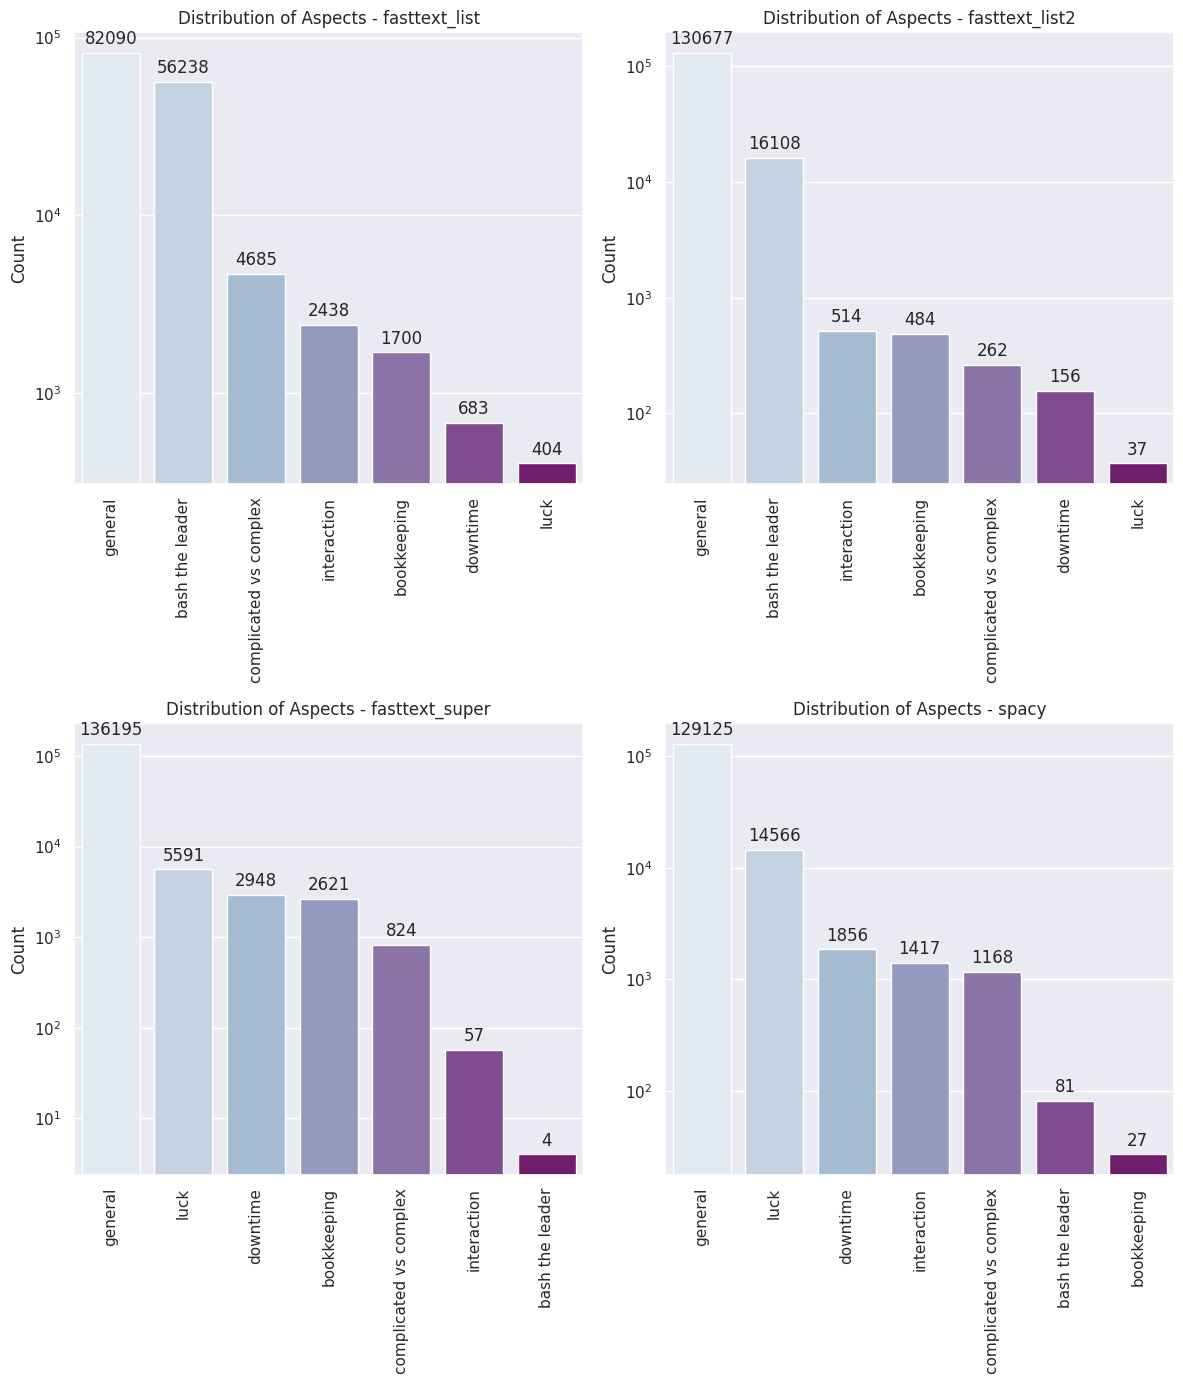

In [ ]:
# Dictionary to map original column names to descriptive labels
column_labels = {
    'fasttext_list': 'fasttext_list',
    'fasttext_list2': 'fasttext_list2',
    'prediction': 'fasttext_super',
    'spacy_pred': 'spacy'
}

# Dictionary to map column names to desired color palettes
column_palettes = {
    'fasttext_list': 'BuPu',
    'fasttext_list2': 'BuPu',
    'prediction': 'BuPu',
    'spacy_pred': 'BuPu'
}

columns_to_plot = ['fasttext_list', 'fasttext_list2', 'prediction', 'spacy_pred']

sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(12, 14))
axs = axs.flatten()

for i, column in enumerate(columns_to_plot):
    # Calculate the count of each label in the current column
    label_counts = df_under[column].value_counts().sort_values(ascending=False)

    # Create the countplot with value counts labels on the current subplot
    ax = sns.countplot(data=df_under, x=column, order=label_counts.index, ax=axs[i], palette=column_palettes[column])

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of Aspects - {column_labels[column]}')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

# 3. Sentiment Classification

## 3.1 Dataset Preparation

In [7]:
# Load the FastText model and dataset
fasttext_model = FastText.load('FastText-Model-For-ABSA.bin')

dataset = CustomDataset(df_under, 'clean_review')
len(dataset.source_vocab.stoi)

10000

## 3.3 Initializing the Model

In [9]:
# Create K-Fold cross-validation object
kfold = KFold(n_splits=config.FOLDS)
model_state_dicts = {}

# Initialize variables and lists

best_model_state_dict = None
best_train_acc = 0.0
best_val_acc = 0.0

train_losses_list = []
val_losses_list = []
train_accs_list = []
val_accs_list = []

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):

    # Create data samplers for training and validation based on fold indices
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # Create data loaders for training and validation
    train_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, sampler=train_sampler,
                              collate_fn=MyCollate(0, config.MAX_LEN))
    val_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, sampler=val_sampler,
                            collate_fn=MyCollate(0, config.MAX_LEN))

    # Define model architecture
    VOCAB_SIZE = len(dataset.source_vocab)
    HIDDEN_DIM = 128
    OUTPUT_DIM = 1
    VOCAB = list(dataset.source_vocab.stoi)

    embedding_layer = get_emb_layer_with_weights(target_vocab=VOCAB, emb_model=fasttext_model, trainable=False)

    model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
    model = model.to(config.DEVICE)

    # Define loss function and optimizer
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"-----------------------------------------------------------{fold}-fold of the model-----------------------------------------------------------")

    # Training loop for multiple epochs
    for epoch in range(config.EPOCHS):
        train_loss, train_correct = train_epochs(train_loader, model, loss_fn, optimizer)
        val_loss, val_correct = val_epochs(val_loader, model, loss_fn)

        train_loss = train_loss / len(train_loader.sampler)
        val_loss = val_loss / len(val_loader.sampler)
        train_acc = (train_correct / len(train_loader.sampler)) * 100
        val_acc = (val_correct / len(val_loader.sampler)) * 100

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc.cpu().numpy().tolist())
        val_accs.append(val_acc.cpu().numpy().tolist())

        print(f"| Train Loss : {train_loss} |", end=" ")
        print(f" Val Loss : {val_loss} |", end=" ")
        print(f"Train Acc : {train_acc} |", end=" ")
        print(f"Val Acc : {val_acc} |")

    # Store the training and validation metrics for this fold
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    train_accs_list.append(train_accs)
    val_accs_list.append(val_accs)

    # Keep track of the best model based on validation accuracy
    if train_acc > best_train_acc and val_acc > best_val_acc:
        best_train_acc = train_acc
        best_val_acc = val_acc
        best_model_state_dict = model.state_dict()
        best_model = model

Words found are: 10000
-----------------------------------------------------------0-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:18<00:00, 26.75it/s]


| Train Loss : 0.6186664134135326 |  Val Loss : 0.9065711030558644 | Train Acc : 66.09214782714844 | Val Acc : 44.89678955078125 |


100%|██████████| 3706/3706 [02:19<00:00, 26.65it/s]


| Train Loss : 0.5331051938609696 |  Val Loss : 0.8526507883668911 | Train Acc : 73.11370086669922 | Val Acc : 48.0639533996582 |


100%|██████████| 3706/3706 [02:15<00:00, 27.26it/s]


| Train Loss : 0.5160118628773764 |  Val Loss : 0.577304771492691 | Train Acc : 73.96873474121094 | Val Acc : 73.26295471191406 |


100%|██████████| 3706/3706 [02:18<00:00, 26.69it/s]


| Train Loss : 0.5063495693604687 |  Val Loss : 0.5638147641437734 | Train Acc : 74.64500427246094 | Val Acc : 72.29154968261719 |


100%|██████████| 3706/3706 [02:13<00:00, 27.84it/s]


| Train Loss : 0.4992277138679013 |  Val Loss : 0.49215665675148856 | Train Acc : 75.10624694824219 | Val Acc : 78.81475830078125 |


100%|██████████| 3706/3706 [02:15<00:00, 27.43it/s]


| Train Loss : 0.4937288885543106 |  Val Loss : 0.525159252474775 | Train Acc : 75.43932342529297 | Val Acc : 73.13815307617188 |


100%|██████████| 3706/3706 [02:19<00:00, 26.66it/s]


| Train Loss : 0.48990655585086096 |  Val Loss : 0.5826546160259957 | Train Acc : 75.7656478881836 | Val Acc : 68.12938690185547 |


100%|██████████| 3706/3706 [02:22<00:00, 26.07it/s]


| Train Loss : 0.4863265655166834 |  Val Loss : 0.5856132137408723 | Train Acc : 75.98151397705078 | Val Acc : 67.14449310302734 |


100%|██████████| 3706/3706 [02:18<00:00, 26.67it/s]


| Train Loss : 0.48382741164595 |  Val Loss : 0.5659150849531228 | Train Acc : 76.08438873291016 | Val Acc : 71.546142578125 |


100%|██████████| 3706/3706 [02:13<00:00, 27.85it/s]


| Train Loss : 0.4806584624570573 |  Val Loss : 0.4893791318036258 | Train Acc : 76.31037139892578 | Val Acc : 77.43186950683594 |


100%|██████████| 3706/3706 [02:12<00:00, 27.88it/s]


| Train Loss : 0.47806930326878283 |  Val Loss : 0.4124107103989823 | Train Acc : 76.48661041259766 | Val Acc : 83.71222686767578 |


100%|██████████| 3706/3706 [02:15<00:00, 27.35it/s]


| Train Loss : 0.4759007595314635 |  Val Loss : 0.5945953435339416 | Train Acc : 76.60213470458984 | Val Acc : 67.75161743164062 |


100%|██████████| 3706/3706 [02:14<00:00, 27.51it/s]


| Train Loss : 0.4739275623255656 |  Val Loss : 0.5369386270569906 | Train Acc : 76.75728607177734 | Val Acc : 73.72166442871094 |


100%|██████████| 3706/3706 [02:19<00:00, 26.50it/s]


| Train Loss : 0.4720086886497748 |  Val Loss : 0.6063786996613949 | Train Acc : 76.9292984008789 | Val Acc : 69.70452880859375 |


100%|██████████| 3706/3706 [02:21<00:00, 26.18it/s]


| Train Loss : 0.4704477620193975 |  Val Loss : 0.47340107681425725 | Train Acc : 77.00688171386719 | Val Acc : 77.9681625366211 |
Words found are: 10000
-----------------------------------------------------------1-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:16<00:00, 27.17it/s]


| Train Loss : 0.5950905733972515 |  Val Loss : 0.6964515079309409 | Train Acc : 65.69329833984375 | Val Acc : 63.801944732666016 |


100%|██████████| 3706/3706 [02:18<00:00, 26.78it/s]


| Train Loss : 0.4751680224643356 |  Val Loss : 0.7747687284713556 | Train Acc : 77.27165222167969 | Val Acc : 58.955074310302734 |


100%|██████████| 3706/3706 [02:23<00:00, 25.89it/s]


| Train Loss : 0.4455374522155771 |  Val Loss : 0.7179612179607942 | Train Acc : 78.64358520507812 | Val Acc : 61.332969665527344 |


100%|██████████| 3706/3706 [02:38<00:00, 23.45it/s]


| Train Loss : 0.4320254446491318 |  Val Loss : 0.7336001829784494 | Train Acc : 79.5306625366211 | Val Acc : 63.093631744384766 |


100%|██████████| 3706/3706 [02:40<00:00, 23.14it/s]


| Train Loss : 0.4235127646811769 |  Val Loss : 0.8419675619552024 | Train Acc : 80.09562683105469 | Val Acc : 59.309226989746094 |


100%|██████████| 3706/3706 [02:40<00:00, 23.12it/s]


| Train Loss : 0.41766779684032934 |  Val Loss : 0.7447463971694868 | Train Acc : 80.54590606689453 | Val Acc : 63.43092346191406 |


100%|██████████| 3706/3706 [02:40<00:00, 23.07it/s]


| Train Loss : 0.4132122886314369 |  Val Loss : 0.698383819908949 | Train Acc : 80.72045135498047 | Val Acc : 63.191444396972656 |


100%|██████████| 3706/3706 [02:39<00:00, 23.20it/s]


| Train Loss : 0.40878009165275825 |  Val Loss : 0.7763764344545808 | Train Acc : 80.9666748046875 | Val Acc : 60.32109832763672 |


100%|██████████| 3706/3706 [02:36<00:00, 23.63it/s]


| Train Loss : 0.4057130932253049 |  Val Loss : 0.7114578243596323 | Train Acc : 81.149658203125 | Val Acc : 62.5 |


100%|██████████| 3706/3706 [02:37<00:00, 23.46it/s]


| Train Loss : 0.40218272134138966 |  Val Loss : 0.7624480892244185 | Train Acc : 81.38997650146484 | Val Acc : 62.24365997314453 |


100%|██████████| 3706/3706 [02:38<00:00, 23.44it/s]


| Train Loss : 0.39966363043670583 |  Val Loss : 0.8446696736782998 | Train Acc : 81.5071792602539 | Val Acc : 60.084999084472656 |


100%|██████████| 3706/3706 [02:37<00:00, 23.48it/s]


| Train Loss : 0.3968266715077986 |  Val Loss : 0.7696424040418667 | Train Acc : 81.569580078125 | Val Acc : 60.90461730957031 |


100%|██████████| 3706/3706 [02:44<00:00, 22.52it/s]


| Train Loss : 0.394344274636159 |  Val Loss : 0.7746901142873831 | Train Acc : 81.82002258300781 | Val Acc : 62.14247512817383 |


100%|██████████| 3706/3706 [02:45<00:00, 22.39it/s]


| Train Loss : 0.3919930318083978 |  Val Loss : 0.7906179101931617 | Train Acc : 81.91024780273438 | Val Acc : 62.98907470703125 |


100%|██████████| 3706/3706 [02:47<00:00, 22.17it/s]


| Train Loss : 0.38942747268598593 |  Val Loss : 0.8073770340815533 | Train Acc : 82.02408599853516 | Val Acc : 61.52185821533203 |
Words found are: 10000
-----------------------------------------------------------2-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:42<00:00, 22.84it/s]


| Train Loss : 0.6309650695233878 |  Val Loss : 0.4842184600608772 | Train Acc : 65.05497741699219 | Val Acc : 83.18267822265625 |


100%|██████████| 3706/3706 [02:43<00:00, 22.60it/s]


| Train Loss : 0.5359319921239157 |  Val Loss : 0.465212028925958 | Train Acc : 73.39112091064453 | Val Acc : 80.85199737548828 |


100%|██████████| 3706/3706 [02:45<00:00, 22.38it/s]


| Train Loss : 0.5111037091273137 |  Val Loss : 0.5236524562223241 | Train Acc : 74.97638702392578 | Val Acc : 71.45845031738281 |


100%|██████████| 3706/3706 [02:44<00:00, 22.53it/s]


| Train Loss : 0.4958753306569438 |  Val Loss : 0.5427916170581893 | Train Acc : 75.8297348022461 | Val Acc : 70.75350952148438 |


100%|██████████| 3706/3706 [02:44<00:00, 22.56it/s]


| Train Loss : 0.48599130722618206 |  Val Loss : 0.9193276600199523 | Train Acc : 76.32555389404297 | Val Acc : 49.13316345214844 |


100%|██████████| 3706/3706 [02:45<00:00, 22.42it/s]


| Train Loss : 0.47981122170695084 |  Val Loss : 0.5187656135734068 | Train Acc : 76.68561553955078 | Val Acc : 72.8345947265625 |


100%|██████████| 3706/3706 [02:44<00:00, 22.50it/s]


| Train Loss : 0.47500598379971204 |  Val Loss : 0.60653443173724 | Train Acc : 76.99085998535156 | Val Acc : 66.04830169677734 |


100%|██████████| 3706/3706 [02:45<00:00, 22.43it/s]


| Train Loss : 0.47048560950123036 |  Val Loss : 0.5304336251436667 | Train Acc : 77.29863739013672 | Val Acc : 72.84133911132812 |


100%|██████████| 3706/3706 [02:43<00:00, 22.70it/s]


| Train Loss : 0.46693014403773975 |  Val Loss : 0.49266100383358136 | Train Acc : 77.5237808227539 | Val Acc : 75.81287384033203 |


100%|██████████| 3706/3706 [02:45<00:00, 22.37it/s]


| Train Loss : 0.46410518114269583 |  Val Loss : 0.6631941616824686 | Train Acc : 77.7759017944336 | Val Acc : 62.0986213684082 |


100%|██████████| 3706/3706 [02:45<00:00, 22.34it/s]


| Train Loss : 0.46166140479988105 |  Val Loss : 0.6633869802958247 | Train Acc : 77.88468170166016 | Val Acc : 61.963706970214844 |


100%|██████████| 3706/3706 [02:42<00:00, 22.80it/s]


| Train Loss : 0.4592529913451758 |  Val Loss : 0.49975578251299313 | Train Acc : 77.92178344726562 | Val Acc : 73.84646606445312 |


100%|██████████| 3706/3706 [02:43<00:00, 22.71it/s]


| Train Loss : 0.45748440450066435 |  Val Loss : 0.5619185470241633 | Train Acc : 78.09464263916016 | Val Acc : 69.65056610107422 |


100%|██████████| 3706/3706 [02:43<00:00, 22.69it/s]


| Train Loss : 0.45484408248905484 |  Val Loss : 0.5188215754351228 | Train Acc : 78.19161224365234 | Val Acc : 73.6474609375 |


100%|██████████| 3706/3706 [02:43<00:00, 22.70it/s]


| Train Loss : 0.4536075537679521 |  Val Loss : 0.6313326565304512 | Train Acc : 78.34761047363281 | Val Acc : 65.42093658447266 |
Words found are: 10000
-----------------------------------------------------------3-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:39<00:00, 23.24it/s]


| Train Loss : 0.6489032110168171 |  Val Loss : 0.49793245938103453 | Train Acc : 59.762882232666016 | Val Acc : 77.3846435546875 |


100%|██████████| 3706/3706 [02:39<00:00, 23.27it/s]


| Train Loss : 0.5497713169888169 |  Val Loss : 0.47571077632440856 | Train Acc : 72.01497650146484 | Val Acc : 76.97989654541016 |


100%|██████████| 3706/3706 [02:41<00:00, 22.94it/s]


| Train Loss : 0.5220102744606206 |  Val Loss : 0.4555341842621002 | Train Acc : 73.8304443359375 | Val Acc : 78.99352264404297 |


100%|██████████| 3706/3706 [02:39<00:00, 23.19it/s]


| Train Loss : 0.5077323627693873 |  Val Loss : 0.4715982263337839 | Train Acc : 74.97470092773438 | Val Acc : 76.75728607177734 |


100%|██████████| 3706/3706 [02:40<00:00, 23.14it/s]


| Train Loss : 0.4999362316909379 |  Val Loss : 0.4762293345305447 | Train Acc : 75.52027130126953 | Val Acc : 75.81287384033203 |


100%|██████████| 3706/3706 [02:40<00:00, 23.08it/s]


| Train Loss : 0.49378894638979814 |  Val Loss : 0.47220556765264005 | Train Acc : 75.81793212890625 | Val Acc : 77.74217987060547 |


100%|██████████| 3706/3706 [02:41<00:00, 22.98it/s]


| Train Loss : 0.48899407020563446 |  Val Loss : 0.4450377859557183 | Train Acc : 76.31121826171875 | Val Acc : 78.98677825927734 |


100%|██████████| 3706/3706 [02:42<00:00, 22.85it/s]


| Train Loss : 0.4850282488492329 |  Val Loss : 0.4749875235609023 | Train Acc : 76.55660247802734 | Val Acc : 76.72018432617188 |


100%|██████████| 3706/3706 [02:41<00:00, 22.92it/s]


| Train Loss : 0.4819717453787665 |  Val Loss : 0.4883723017401265 | Train Acc : 76.71849822998047 | Val Acc : 76.09281921386719 |


100%|██████████| 3706/3706 [02:40<00:00, 23.15it/s]


| Train Loss : 0.47870936017549814 |  Val Loss : 0.45543613286836687 | Train Acc : 76.97736358642578 | Val Acc : 78.44036865234375 |


100%|██████████| 3706/3706 [02:43<00:00, 22.65it/s]


| Train Loss : 0.47622846054487206 |  Val Loss : 0.4912337084847145 | Train Acc : 77.16625213623047 | Val Acc : 75.45197296142578 |


100%|██████████| 3706/3706 [02:48<00:00, 22.06it/s]


| Train Loss : 0.47357198124358413 |  Val Loss : 0.4927589559612954 | Train Acc : 77.33405303955078 | Val Acc : 75.25296783447266 |


100%|██████████| 3706/3706 [02:50<00:00, 21.73it/s]


| Train Loss : 0.4708499689031085 |  Val Loss : 0.48949533353544095 | Train Acc : 77.4925765991211 | Val Acc : 75.25634002685547 |


100%|██████████| 3706/3706 [02:53<00:00, 21.36it/s]


| Train Loss : 0.4685680270918755 |  Val Loss : 0.528536515948712 | Train Acc : 77.586181640625 | Val Acc : 71.3100357055664 |


100%|██████████| 3706/3706 [02:46<00:00, 22.22it/s]


| Train Loss : 0.46624597813381224 |  Val Loss : 0.45136049762971325 | Train Acc : 77.7337417602539 | Val Acc : 78.43362426757812 |
Words found are: 10000
-----------------------------------------------------------4-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:44<00:00, 22.53it/s]


| Train Loss : 0.6089292044936806 |  Val Loss : 0.6115629589371082 | Train Acc : 65.26325225830078 | Val Acc : 67.89665222167969 |


100%|██████████| 3706/3706 [02:43<00:00, 22.64it/s]


| Train Loss : 0.5020262224854036 |  Val Loss : 0.5873920690736704 | Train Acc : 75.52786254882812 | Val Acc : 69.56961822509766 |


100%|██████████| 3706/3706 [02:45<00:00, 22.44it/s]


| Train Loss : 0.48135844302045544 |  Val Loss : 0.66611484913844 | Train Acc : 76.68814086914062 | Val Acc : 64.03804779052734 |


100%|██████████| 3706/3706 [02:44<00:00, 22.50it/s]


| Train Loss : 0.4681912070704163 |  Val Loss : 0.6032442878017024 | Train Acc : 77.49763488769531 | Val Acc : 68.74662780761719 |


100%|██████████| 3706/3706 [02:42<00:00, 22.84it/s]


| Train Loss : 0.46024901632981496 |  Val Loss : 0.6995373892256587 | Train Acc : 78.0533218383789 | Val Acc : 60.702239990234375 |


100%|██████████| 3706/3706 [02:44<00:00, 22.59it/s]


| Train Loss : 0.4545102905114149 |  Val Loss : 0.6164442909387917 | Train Acc : 78.32062530517578 | Val Acc : 69.15812683105469 |


100%|██████████| 3706/3706 [02:44<00:00, 22.53it/s]


| Train Loss : 0.4498757822403892 |  Val Loss : 0.6238618615634751 | Train Acc : 78.71947479248047 | Val Acc : 67.1310043334961 |


100%|██████████| 3706/3706 [02:43<00:00, 22.65it/s]


| Train Loss : 0.4454022299435997 |  Val Loss : 0.6241756653180974 | Train Acc : 78.9656982421875 | Val Acc : 66.97247314453125 |


100%|██████████| 3706/3706 [02:44<00:00, 22.50it/s]


| Train Loss : 0.4422398584995859 |  Val Loss : 0.7123631956573441 | Train Acc : 79.19084167480469 | Val Acc : 62.034542083740234 |


100%|██████████| 3706/3706 [02:46<00:00, 22.28it/s]


| Train Loss : 0.4387430658717768 |  Val Loss : 0.8659911903894983 | Train Acc : 79.40502166748047 | Val Acc : 61.53197479248047 |


100%|██████████| 3706/3706 [02:47<00:00, 22.19it/s]


| Train Loss : 0.43497559708064143 |  Val Loss : 0.6651600591729798 | Train Acc : 79.65545654296875 | Val Acc : 67.29965209960938 |


100%|██████████| 3706/3706 [02:47<00:00, 22.17it/s]


| Train Loss : 0.4318347676173134 |  Val Loss : 0.6775342240503397 | Train Acc : 79.79037475585938 | Val Acc : 64.55072784423828 |


100%|██████████| 3706/3706 [02:48<00:00, 22.05it/s]


| Train Loss : 0.4291747388602332 |  Val Loss : 0.6675136570215097 | Train Acc : 79.92444610595703 | Val Acc : 66.6756591796875 |


100%|██████████| 3706/3706 [02:46<00:00, 22.26it/s]


| Train Loss : 0.4264390627580659 |  Val Loss : 0.6619400562818026 | Train Acc : 79.95480346679688 | Val Acc : 67.35698699951172 |


100%|██████████| 3706/3706 [02:48<00:00, 22.00it/s]


| Train Loss : 0.4237442584502266 |  Val Loss : 0.6881899733962848 | Train Acc : 80.15970611572266 | Val Acc : 65.7818374633789 |


In [11]:
print('Best train acc:', best_train_acc)
print('Best val acc:', best_val_acc)

Best train acc: tensor(77.7337)
Best val acc: tensor(78.4336)


In [10]:
torch.save(best_model_state_dict, 'best_model.pt')

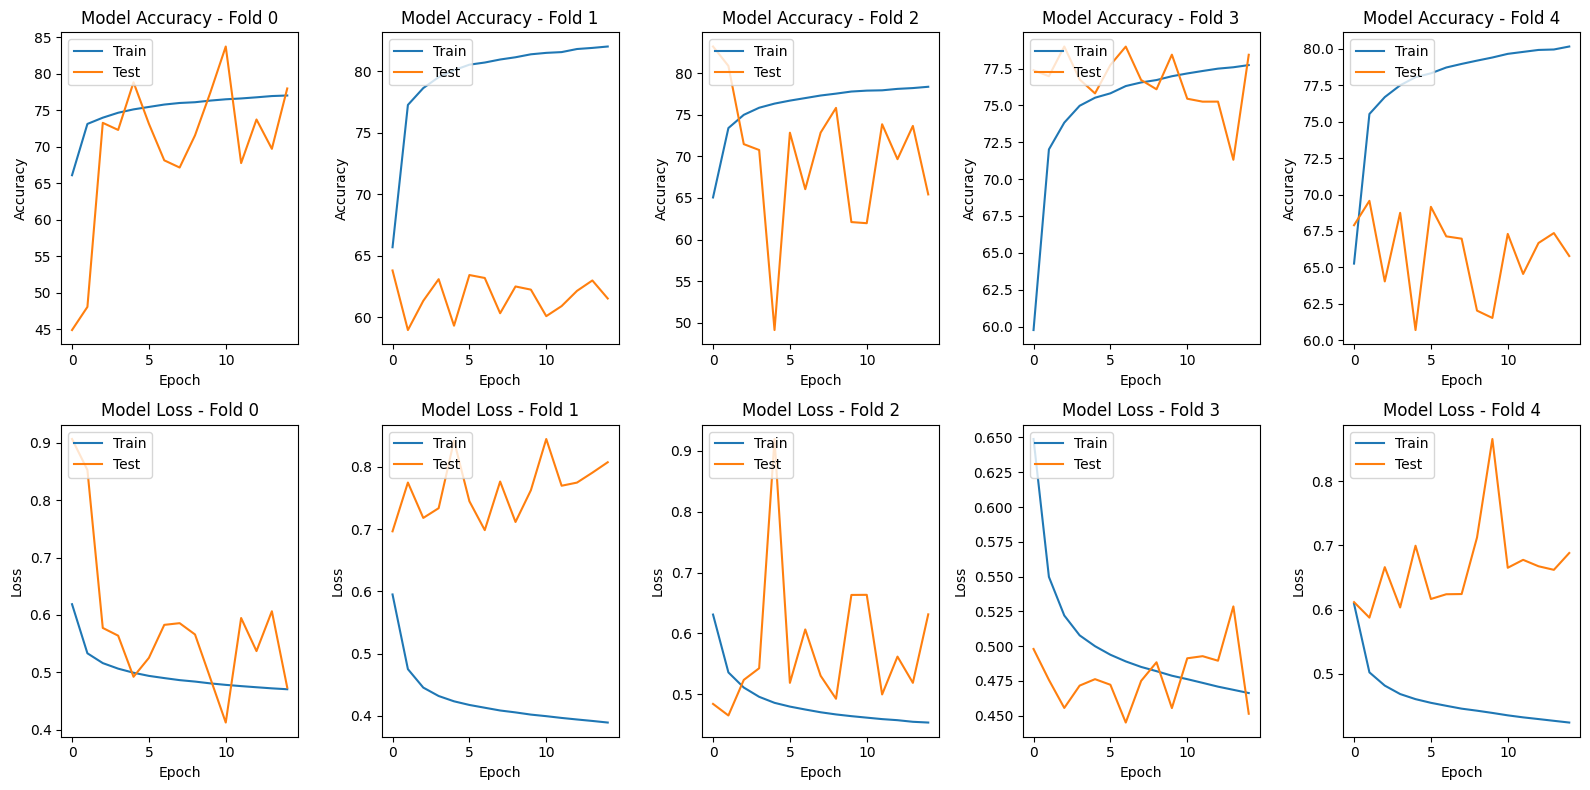

In [12]:
# Creating subplots for accuracy and loss
fig, axs = plt.subplots(2, config.FOLDS, figsize=(16, 8))

for fold in range(config.FOLDS):
    axs[0, fold].plot(train_accs_list[fold])
    axs[0, fold].plot(val_accs_list[fold])
    axs[0, fold].set_title(f'Model Accuracy - Fold {fold}')
    axs[0, fold].set_ylabel('Accuracy')
    axs[0, fold].set_xlabel('Epoch')
    axs[0, fold].legend(['Train', 'Test'], loc='upper left')

    axs[1, fold].plot(train_losses_list[fold])
    axs[1, fold].plot(val_losses_list[fold])
    axs[1, fold].set_title(f'Model Loss - Fold {fold}')
    axs[1, fold].set_ylabel('Loss')
    axs[1, fold].set_xlabel('Epoch')
    axs[1, fold].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# 4. Inference

In [8]:
# Loading the model
VOCAB_SIZE = len(dataset.source_vocab)
HIDDEN_DIM = 128
OUTPUT_DIM = 1
VOCAB = list(dataset.source_vocab.stoi)
embedding_layer = get_emb_layer_with_weights(target_vocab=VOCAB, emb_model=fasttext_model, trainable=False)

model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
model.load_state_dict(torch.load('best_model.pt'))

Words found are: 10000


<All keys matched successfully>

In [11]:
random.seed(33)

# Create an empty list to store the information as dictionaries
results_data = []
# Sample random sentences
sample = random.sample(list(df_under['comment']), k=25)

for sentence in sample:
    row = df_under[df_under['comment'] == sentence].iloc[0]  # Get the entire row

    # Process the sentence
    a = infer_processing(sentence, lemmatizer, stop_words, dataset).to(config.DEVICE)
    model.eval()
    sentiment = model(a)
    sentiment = sentiment.cpu().detach().numpy()[0]

    sentiment_label = 'Positively' if sentiment > 0.5 else 'Negatively'

    # Create a dictionary with all the information
    result_dict = {
        'Comment': sentence,
        'fasttext_list': row['fasttext_list'],
        'fasttext_list2': row['fasttext_list2'],
        'prediction': row['prediction'],
        'aspect_spacy': row['spacy_pred'],
        'Sentiment': sentiment_label
    }
    results_data.append(result_dict)

# Create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_data)

In [12]:
# Create the new column based on the conditions
results_df['Aspects'] = results_df.apply(determine_new_value, axis=1)
results_df

,Comment,fasttext_list,fasttext_list2,prediction,aspect_spacy,Sentiment,Aspects
0,One of the best plastic storage solutions afte...,general,general,general,general,Positively,general
1,Great game to play especially with five player...,bash the leader,general,general,general,Positively,bash the leader
2,Hilarious game. The negotiations can get a bi...,general,general,general,general,Negatively,general
3,Anything Lovecraft is fine with me. This was a...,general,general,general,general,Positively,general
4,"My only perfect-10. For me, this game is Arkh...",bash the leader,general,general,general,Positively,bash the leader
5,This K&K title feels like a blend of Puerto Ri...,bash the leader,general,general,general,Positively,bash the leader
6,"Even though the score can be close, the game i...",bash the leader,bash the leader,general,general,Negatively,bash the leader
7,FULLY SLEEVED 500 x Swan PanAsia Standard Eur...,complicated vs complex,general,general,downtime,Positively,"complicated vs complex, downtime"
8,Who Would have thought that such a stupid and ...,bash the leader,general,general,general,Negatively,bash the leader
9,Love jigsaw puzzles (ever heard of Stave Puzzl...,bash the leader,general,general,general,Negatively,bash the leader
